In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import reverse_geocoder as rg
from geopy.geocoders import Nominatim
# from global_land_mask import globe
from tqdm import tqdm

from matplotlib import image

EAST_POINT = -113.8
WEST_POINT = -124.49
NORTH_POINT = 42.05
SOUTH_POINT = 32.45


In [8]:
def plot_lat_long(df, s=4, c='b',
    save_file_path=None, 
    cal_pic_file_path='california.png'):
    """ Function to plot lat / long points on california map"""
    image_array = image.imread(cal_pic_file_path)
    _, ax = plt.subplots(figsize=(10,8))
    extent = [WEST_POINT, EAST_POINT, SOUTH_POINT, NORTH_POINT]
    ax.imshow(image_array, extent=extent)
    for _, row in df.iterrows():
        ax.scatter(row['lon'], row['lat'], c=c, s=s)
    ax.set_xlabel("Longitude", fontsize=16)
    ax.set_ylabel("Latitude", fontsize=16)
    if save_file_path is not None:
        plt.savefig(save_file_path)
    plt.show()

In [12]:
loc = pd.read_csv('uscities.csv')

In [26]:
ca_400 = loc[loc['state_id'] == 'CA'].reset_index().sort_values('population', ascending=False)[:400]
ca_400[['city', 'lat', 'lng', 'population']].rename(columns={'lng':'lon'}).round(3).to_csv('400_cities.csv')

In [28]:
ca_600 = loc[loc['state_id'] == 'CA'].reset_index().sort_values('population', ascending=False)[:600]
ca_600[['city', 'lat', 'lng', 'population']].rename(columns={'lng':'lon'}).round(3).to_csv('600_cities.csv')

In [33]:
ca_all = loc[loc['state_id'] == 'CA'].reset_index().sort_values('population', ascending=False)
ca_all = ca_all[['city', 'lat', 'lng', 'population']].rename(columns={'lng':'lon'}).round(3)
ca_all.to_csv('all_cities.csv')

In [34]:
ca_all

,city,lat,lon,population
0,Los Angeles,34.114,-118.407,12750807
1,San Francisco,37.756,-122.443,3592294
2,San Diego,32.831,-117.122,3220118
3,Riverside,33.938,-117.395,2107852
4,Sacramento,38.567,-121.468,1898019
...,...,...,...,...
1465,Keeler,36.485,-117.872,10
1466,Sugarloaf Village,35.827,-118.635,9
1467,Pearsonville,35.819,-117.876,7
1468,Cartago,36.312,-118.026,5


In [37]:
locations = pd.read_csv('cal_cities_lat_long.csv').rename(columns={'Name':'city'}).set_index('city')
locations.head()

,Latitude,Longitude
city,,
Adelanto,34.582769,-117.409214
Agoura Hills,34.153339,-118.761675
Alameda,37.765206,-122.241636
Albany,37.886869,-122.297747
Alhambra,34.095286,-118.127014


In [53]:
tmp = locations.join(ca_all.set_index(['city']), how='left') \
    .drop(columns=['lat', 'lon']).rename(columns={'Latitude':'lat', 'Longitude':'lon'}) \
    .sort_values('population', ascending=False).dropna()
tmp.round(4).to_csv('../etl_pipeline/locations.csv')

In [55]:
tmp.round(4)

,lat,lon,population
city,,,
Los Angeles,34.0522,-118.2437,12750807.0
San Francisco,37.7749,-122.4194,3592294.0
San Diego,32.7153,-117.1573,3220118.0
Riverside,33.9534,-117.3962,2107852.0
Sacramento,38.5816,-121.4944,1898019.0
...,...,...,...
Tehama,40.0271,-122.1233,373.0
Trinidad,41.0593,-124.1431,355.0
Industry,34.0197,-117.9587,202.0


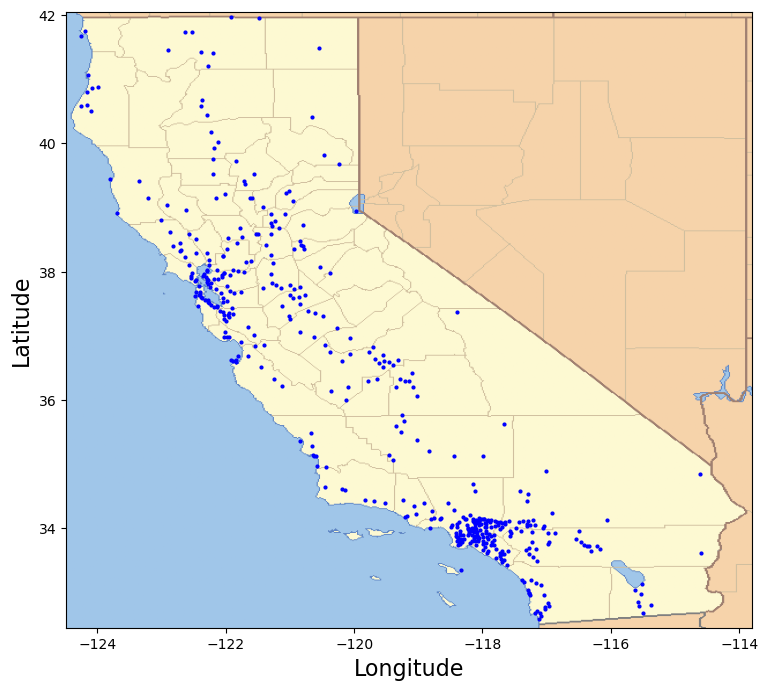

In [49]:
plot_lat_long(tmp)

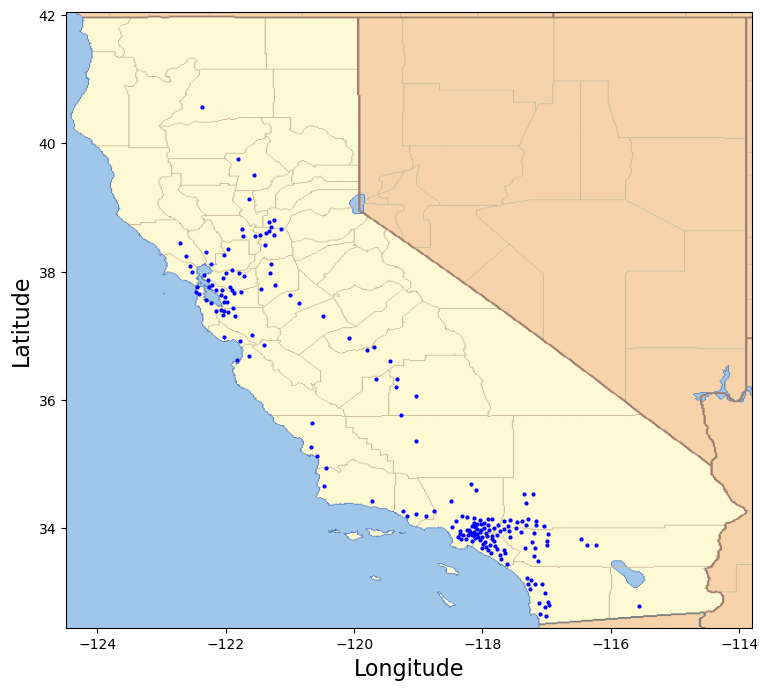

In [11]:
df_lat_long = pd.read_csv('../etl_pipeline/locations.csv')
plot_lat_long(df_lat_long, save_file_path='200_cities.png')

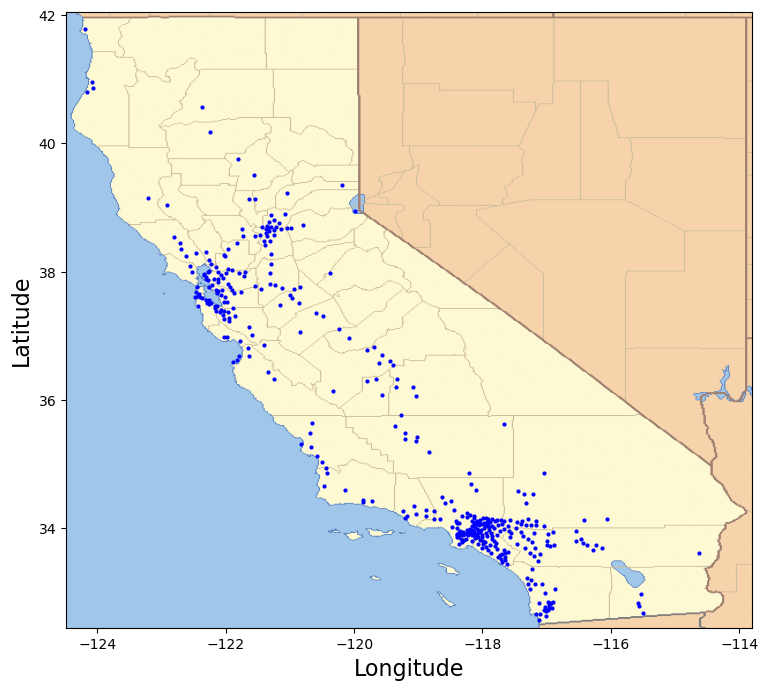

In [27]:
df_lat_long = pd.read_csv('400_cities.csv')
plot_lat_long(df_lat_long, save_file_path='400_cities.png')

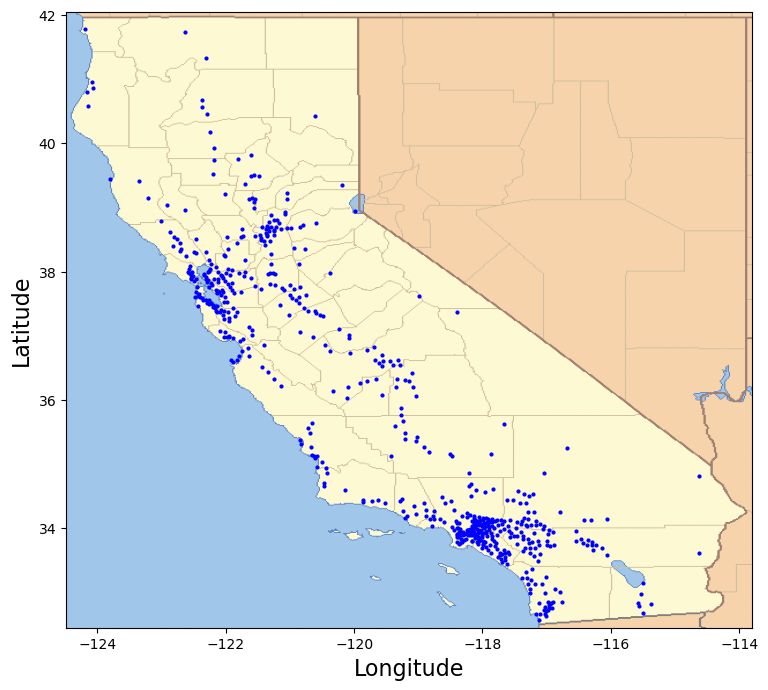

In [29]:
df_lat_long = pd.read_csv('600_cities.csv')
plot_lat_long(df_lat_long, save_file_path='600_cities.png')

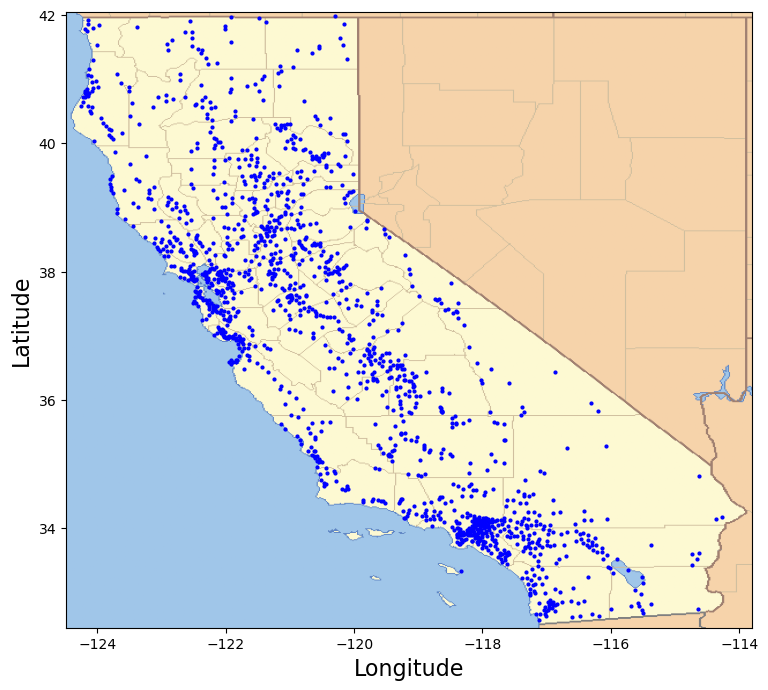

In [31]:
df_lat_long = pd.read_csv('all_cities.csv')
plot_lat_long(df_lat_long, save_file_path='all_cities.png')

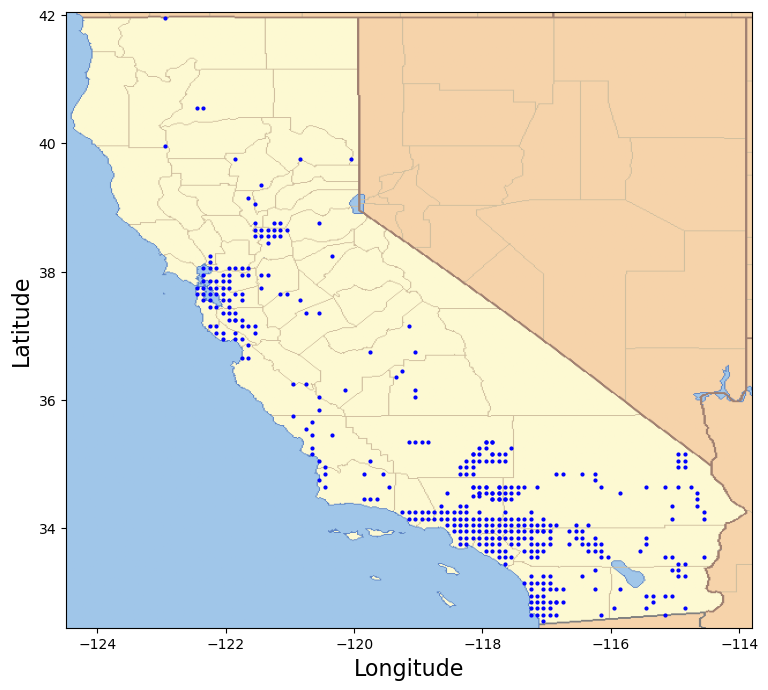

In [9]:
df_model_lat_long = pd.read_csv('data/cal_model_all_lat_long.csv')
plot_lat_long(df_model_lat_long, save_file_path='data/cal_model_all_plot.png')

## Compute all coordinates within extremes of California Lat / Long borders

In [5]:
RESOLUTION = 5  # In Miles

earth_radius = 3960.0
degrees_to_radians = math.pi/180.0
radians_to_degrees = 180.0/math.pi

delta_lat = math.sin(math.pi / 3) * (RESOLUTION / earth_radius) * radians_to_degrees

def delta_long(latitude):
    "Given a latitude and a distance west, return the change in longitude."
    # Find the radius of a circle around the earth at given latitude.
    global RESOLUTION
    r = earth_radius * math.cos(latitude * degrees_to_radians)
    return (RESOLUTION / r) * radians_to_degrees

coords = []
counter = 0
lat = SOUTH_POINT
while lat <= NORTH_POINT:
    long = WEST_POINT
    while long <= EAST_POINT:
        if counter % 2 == 0:
            coord = (lat, long)
        else:
            coord = (lat, long + delta_long(lat) / 2)
        if globe.is_land(*coord):
            coords.append(coord)
        long += delta_long(lat)
    lat += delta_lat
    counter += 1

## Filter coorinates to remove points in ocean or other states

In [12]:
ca_coords = []

geolocator = Nominatim(user_agent="geoapiExercises")

for coord in tqdm(coords):
    geo_info = geolocator.reverse(','.join([str(c) for c in coord]))
    state = geo_info.raw['address']['state']
    if state == 'California':
        ca_coords.append(coord)

ca_coords = pd.DataFrame(ca_coords, columns=['Latitude', 'Longitude'])

100%|██████████| 13435/13435 [1:52:20<00:00,  1.99it/s] 


In [ ]:
ca_coords.to_csv('data/cal_inference_5_MILES_lat_long.csv')

## Plot point of CA map and save image

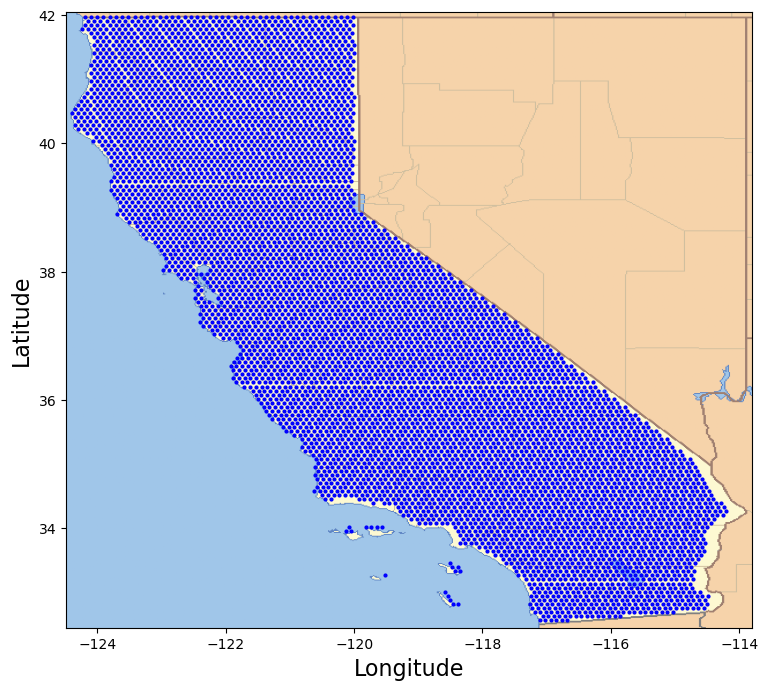

In [18]:
plot_lat_long(ca_coords, save_file_path='data/test')

## Do the same but for a 10 mile resolution

In [53]:
RESOLUTION = 10  # In Miles

earth_radius = 3960.0
degrees_to_radians = math.pi/180.0
radians_to_degrees = 180.0/math.pi

delta_lat = math.sin(math.pi / 3) * (RESOLUTION / earth_radius) * radians_to_degrees

def delta_long(latitude):
    "Given a latitude and a distance west, return the change in longitude."
    # Find the radius of a circle around the earth at given latitude.
    global RESOLUTION
    r = earth_radius * math.cos(latitude * degrees_to_radians)
    return (RESOLUTION / r) * radians_to_degrees

coords = []
counter = 0
lat = SOUTH_POINT
while lat <= NORTH_POINT:
    long = WEST_POINT
    while long <= EAST_POINT:
        if counter % 2 == 0:
            coord = (lat, long)
        else:
            coord = (lat, long + delta_long(lat) / 2)
        if globe.is_land(*coord):
            coords.append(coord)
        long += delta_long(lat)
    lat += delta_lat
    counter += 1

In [55]:
ca_coords = []

geolocator = Nominatim(user_agent="geoapiExercises")

for coord in tqdm(coords):
    geo_info = geolocator.reverse(','.join([str(c) for c in coord]))
    state = geo_info.raw['address']['state']
    if state == 'California':
        ca_coords.append(coord)

ca_coords = pd.DataFrame(ca_coords, columns=['Latitude', 'Longitude'])

100%|██████████| 3359/3359 [29:40<00:00,  1.89it/s]  


In [57]:
ca_coords.to_csv('data/cal_inference_10_MILES_lat_long.csv')

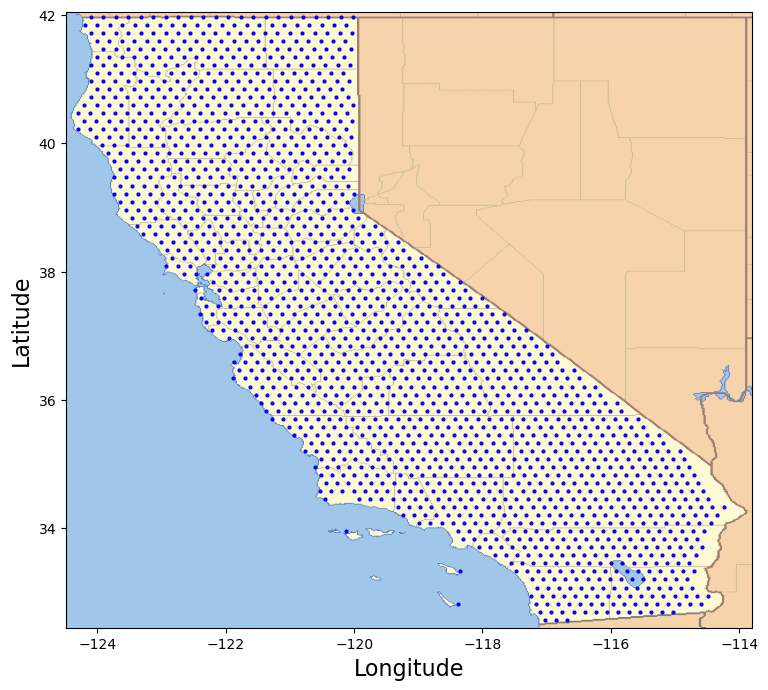

In [56]:
plot_lat_long(ca_coords, save_file_path='data/cal_inference_10_MILES_plot.png')

## Select a subset of the solar output locations

In [42]:
def plot_model_lat_long(df, centroids, s=4, c='r',
    save_file_path=None, 
    cal_pic_file_path='data/california.png'):
    """ Function to plot lat / long points on california map"""
    image_array = image.imread(cal_pic_file_path)
    _, ax = plt.subplots(figsize=(10,8))
    extent = [WEST_POINT, EAST_POINT, SOUTH_POINT, NORTH_POINT]
    ax.imshow(image_array, extent=extent)
    for _, row in df.iterrows():
        ax.scatter(row['Longitude'], row['Latitude'], c='k', s=s-2)
    ax.scatter(centroids[:,1], centroids[:,0], c=c, s=s + 20)
    ax.set_xlabel("Longitude", fontsize=16)
    ax.set_ylabel("Latitude", fontsize=16)
    ax.set_yticks(np.arange(32.5,42,0.5))
    ax.set_xticks(np.arange(-124,-114,0.5))
    ax.set_xticklabels(np.arange(-124,-114,0.5), rotation=45)
    
    if save_file_path is not None:
        plt.savefig(save_file_path)
    plt.show()

In [47]:
def compute_distances(X, centroids):
    """ Function to Compute the distances to each centroid """
    dist_components = X[:,:,None] - centroids.T[None,:,:]
    return np.sqrt(np.sum(dist_components ** 2, axis=1))

In [51]:
initial_points = np.array([
    [-114.5, 34], 
    [-116.75, 32.6], 
    [-118.75, 34.25], 
    [-120.25, 35.25], 
    [-119.25, 37], 
    [-121.75, 37.5], 
    [-116.5, 34.75], 
    [-120, 39.75], 
    [-122.25, 40.5], 
    [-123, 42]
])

X = df_model_lat_long[['Longitude', 'Latitude']].values

new_centroids = X[np.argmin(compute_distances(X, initial_points), axis=0)]
new_centroids = pd.DataFrame(new_centroids, columns=['Longitude', 'Latitude'])
new_centroids[['Latitude','Longitude']].to_csv('data/cal_model_subset_lat_long.csv', index=False)
new_centroids = new_centroids[['Latitude','Longitude']].values
new_centroids

array([[  34.15, -114.55],
       [  32.65, -116.85],
       [  34.25, -118.75],
       [  35.45, -120.35],
       [  37.15, -119.15],
       [  37.55, -121.75],
       [  34.85, -116.45],
       [  39.75, -120.05],
       [  40.55, -122.35],
       [  41.95, -122.95]])

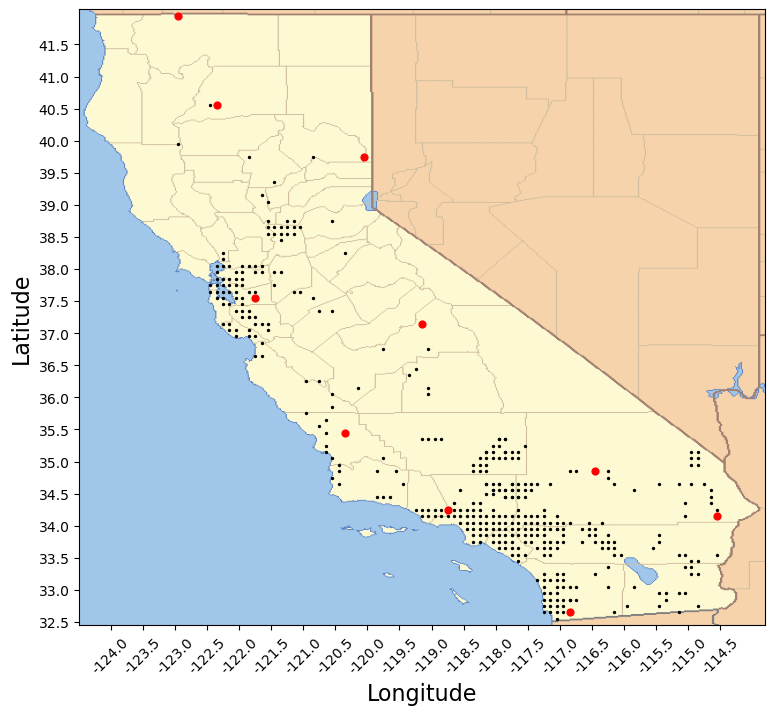

In [52]:
plot_model_lat_long(df_model_lat_long, new_centroids, save_file_path='data/cal_model_subset_plot.png')